In [10]:
%pip install wget             # to install the wget library in order to download data

In [11]:
import os
import wget
import zipfile
import torch
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [12]:
batch_size = 16
image_size = 256

In [14]:
def download_celeba_dataset(data_root="datasets"):
    """
    Downloads and extracts the CelebA dataset from the specified URL into the given directory.

    Parameters:
    - data_root (str): The root directory where the dataset will be stored. Default is "datasets".

    Returns:
    None
    """
    import os
    import zipfile
    import wget

    base_url = "https://graal.ift.ulaval.ca/public/celeba/"
    file_list = [
        "img_align_celeba.zip",
        "list_attr_celeba.txt",
        "identity_CelebA.txt",
        "list_bbox_celeba.txt",
        "list_landmarks_align_celeba.txt",
        "list_eval_partition.txt",
    ]

    # Path to folder with the dataset
    dataset_folder = f"{data_root}/celeba"
    os.makedirs(dataset_folder, exist_ok=True)

    # Download files if not already downloaded
    for file in file_list:
        url = f"{base_url}/{file}"
        if not os.path.exists(f"{dataset_folder}/{file}"):
            wget.download(url, f"{dataset_folder}/{file}")

    # Extract the main archive
    with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
        ziphandler.extractall(dataset_folder)

download_celeba_dataset()

In [15]:
def create_transforms(image_size):
    """
    Creates a composition of transformations for preprocessing images.

    Parameters:
    - image_size (int or tuple): The desired size of the output images. If int, the image will be resized to (image_size, image_size).
      If tuple, it should be (height, width).

    Returns:
    torchvision.transforms.Compose: A composition of transformations.
    """
    import torchvision.transforms as tfms

    transforms = tfms.Compose(
        [
            tfms.Resize((image_size, image_size)),
            tfms.ToTensor(),
        ]
    )
    return transforms

transforms = create_transforms(image_size)

In [17]:
# Define a CelebA dataset for training.
# - `data_root` specifies the root directory where the CelebA dataset is stored.
# - `split="train"` indicates that we want to use the training split of the dataset.
# - `target_type=["attr", "landmarks"]` specifies that we want to load both attribute labels and landmarks for each image.
# - `transform=transforms` applies the previously defined transformations to preprocess the images.
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"], transform=transforms)


In [18]:
class ConvAE3(nn.Module):
    """
    Convolutional Autoencoder with 3 convolutional layers.

    Architecture:
    - Encoder:
        - Input: RGB images of size 256x256x3
        - Conv1: 3->16 channels, kernel_size=3, stride=1, padding=1
        - ReLU activation
        - MaxPool: kernel_size=2, stride=2
        - Conv2: 16->32 channels, kernel_size=3, stride=2, padding=1
        - ReLU activation
        - MaxPool: kernel_size=2, stride=2
        - Conv3: 32->16 channels, kernel_size=3, stride=2, padding=1
        - ReLU activation
    - Flatten: Flattens the feature maps to 1D
    - Linear layer: 16*16*16 -> 32*32*16
    - Decoder:
        - Unflatten: Reshapes the flattened tensor to 3D tensor
        - ConvTranspose2d: 16->32 channels, kernel_size=3, stride=2, padding=1, output_padding=1
        - ReLU activation
        - ConvTranspose2d: 32->16 channels, kernel_size=3, stride=2, padding=1, output_padding=1
        - ReLU activation
        - ConvTranspose2d: 16->3 channels (RGB), kernel_size=3, stride=2, padding=1, output_padding=1
        - Tanh activation

    Attributes:
    - encoder (nn.Sequential): Encoder module comprising convolutional layers.
    - flatten (nn.Flatten): Flattens the feature maps to 1D.
    - linear (nn.Linear): Linear layer for dimensionality reduction.
    - decoder (nn.Sequential): Decoder module comprising transposed convolutional layers.
    """

    def __init__(self):
        super(ConvAE3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # RGB, 256x256x3 -> 256x256x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 256x256x16 -> 128x128x16
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 128x128x16 -> 64x64x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x32 -> 32x32x32
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # 32x32x32 -> 16x16x16
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(16*16*16, 32*32*16)

        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (16, 32, 32)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32x16 -> 64x64x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64x32 -> 128x128x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128x16 -> 256x256x3
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Reconstructed output tensor of shape (batch_size, channels, height, width).
        """
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.decoder(x)
        return x

    def encodage(self, x):
        """
        Encodes the input tensor using the encoder part of the autoencoder.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Encoded tensor.
        """
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def decodage(self, x):
        """
        Decodes the input tensor using the decoder part of the autoencoder.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Decoded tensor.
        """
        x = self.decoder(x)
        return x


In [19]:
# Model Initialization

# Create an instance of the ConvAE3 model.
model = ConvAE3()

# Validation using Mean Squared Error (MSE) Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with learning rate (lr) = 0.001
# and weight decay of 1e-8
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-8)


In [20]:
def print_model_summary(model):
    """
    Prints a summary of the model's architecture, parameters, and memory usage using the torchinfo package.

    Parameters:
    - model: The PyTorch model for which the summary is to be printed.

    Returns:
    None
    """
    # Install the torchinfo package using pip if not already installed.
    try:
        import torchinfo
    except ImportError:
        print("torchinfo package not found. Installing...")
        !pip install torchinfo
        import torchinfo

    # Import the summary function from torchinfo package.
    from torchinfo import summary

    # Print the summary of the model.
    print(summary(model))

print_model_summary(model)

torchinfo package not found. Installing...
Layer (type:depth-idx)                   Param #
ConvAE3                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       4,624
│    └─ReLU: 2-8                         --
├─Flatten: 1-2                           --
├─Linear: 1-3                            67,125,248
├─Sequential: 1-4                        --
│    └─ReLU: 2-9                         --
│    └─Unflatten: 2-10                   --
│    └─ConvTranspose2d: 2-11             4,640
│    └─ReLU: 2-12                        --
│    └─ConvTranspose2d: 2-13             4,624
│    └─ReLU: 2-14                        --
│    └─ConvTranspose2d: 2-15             435
│    └

In [21]:
# Define the size of the subset
subset_size = 5000

# Generate random indices for selecting images
indices = np.random.choice(len(train_dataset), subset_size, replace=False)

# Create a Subset of the dataset using the random indices
train_subset = Subset(train_dataset, indices)

# Create a DataLoader for the subset
subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)


cuda
Epoch [1/60], Loss: 0.001305
Epoch [2/60], Loss: 0.000387
Epoch [3/60], Loss: 0.000264
Epoch [4/60], Loss: 0.000221
Epoch [5/60], Loss: 0.000195
Epoch [6/60], Loss: 0.000177
Epoch [7/60], Loss: 0.000166
Epoch [8/60], Loss: 0.000154
Epoch [9/60], Loss: 0.000148
Epoch [10/60], Loss: 0.000145
Epoch [11/60], Loss: 0.000139
Epoch [12/60], Loss: 0.000134
Epoch [13/60], Loss: 0.000128
Epoch [14/60], Loss: 0.000131
Epoch [15/60], Loss: 0.000124
Epoch [16/60], Loss: 0.000119
Epoch [17/60], Loss: 0.000116
Epoch [18/60], Loss: 0.000116
Epoch [19/60], Loss: 0.000112
Epoch [20/60], Loss: 0.000111
Epoch [21/60], Loss: 0.000108
Epoch [22/60], Loss: 0.000107
Epoch [23/60], Loss: 0.000107
Epoch [24/60], Loss: 0.000105
Epoch [25/60], Loss: 0.000102
Epoch [26/60], Loss: 0.000102
Epoch [27/60], Loss: 0.000099
Epoch [28/60], Loss: 0.000097
Epoch [29/60], Loss: 0.000097
Epoch [30/60], Loss: 0.000095
Epoch [31/60], Loss: 0.000094
Epoch [32/60], Loss: 0.000093
Epoch [33/60], Loss: 0.000094
Epoch [34/60],

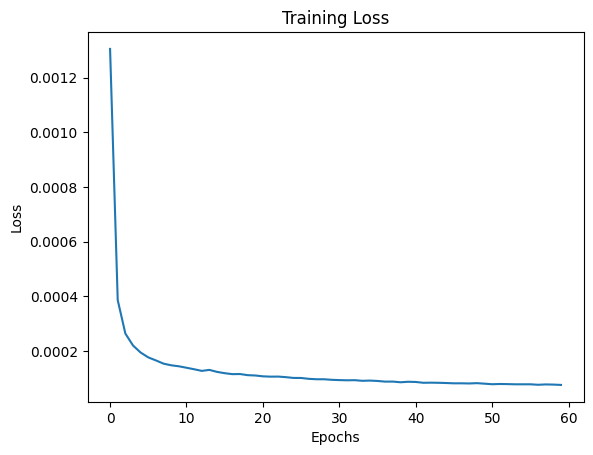

In [22]:
#Trains the model over a specified number of epochs, calculating and storing the loss at each epoch.

# Number of epochs
epochs = 60

#Data Loader
loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Lists to store losses
losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)


# Loop over epochs
for epoch in range(epochs):
    epoch_loss = 0.0  # Initialize epoch loss

    # Loop over data
    for images, _ in subset_loader:
        images = images.to(device)  # Move images to GPU
        optimizer.zero_grad()  # Reset gradients

        # Pass images through the model
        reconstructed = model(images)
        # Calculate loss

        loss = loss_function(reconstructed, images)


        # Backpropagation
        loss.backward()

        # Optimization
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item() * images.size(0)

    # Calculate average epoch loss
    epoch_loss /= len(loader.dataset)

    # Store the average loss for this epoch
    losses.append(epoch_loss)

    # Print average loss every epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.6f}")

# Plotting the losses
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

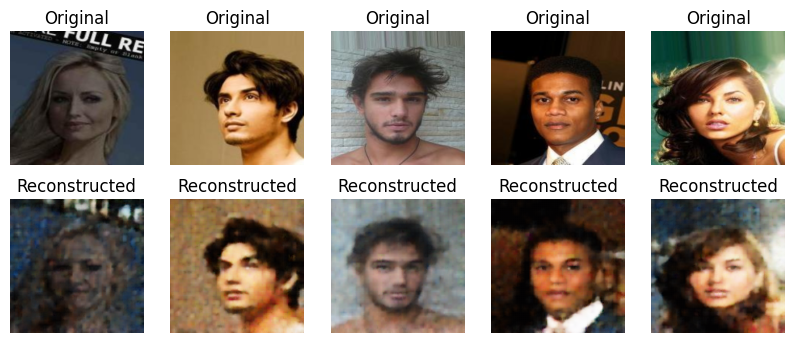

In [23]:
def display_original_and_reconstructed_images(train_dataset, model, device):
    """
    Displays randomly selected original and reconstructed images.

    Parameters:
    - train_dataset (torch.utils.data.Dataset): The dataset containing the images.
    - model (torch.nn.Module): The trained autoencoder model.
    - device: The device (e.g., 'cuda' or 'cpu') on which the model is located.

    Returns:
    None
    """
    import random

    # Randomly select 5 indices of images
    random_indices = random.sample(range(len(train_dataset)), 5)

    # Create subsets of images and their corresponding reconstructions
    original_images = [train_dataset[i][0].to(device) for i in random_indices]
    reconstructed_images = [model(original_images[i].unsqueeze(0)).squeeze(0) for i in range(5)]

    # Display original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original image
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_images[i].cpu().permute(1, 2, 0))
        plt.title('Original')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_images[i].detach().cpu().permute(1, 2, 0))
        plt.title('Reconstructed')
        plt.axis('off')

    plt.show()

display_original_and_reconstructed_images(train_dataset, model, device)


In [116]:
def save_model_parameters(model, file_path):
    """
    Saves the parameters of the model to a file.

    Parameters:
    - model (torch.nn.Module): The model whose parameters are to be saved.
    - file_path (str): The file path where the parameters will be saved.

    Returns:
    None
    """
    # Saving parameters
    torch.save(model.state_dict(), file_path)

save_model_parameters(model, "autoencoder.pth")
